In [1]:
from utils import *
import tqdm
import ntpath
import json
import collections
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt


In [58]:
fpaths = glob.glob("data/nlp390_bryozoa/*")
fpaths = glob.glob("data/*.tsv")

fpaths = glob.glob("/uio/kant/nhm-sfs-u2/bjorntko/TDM Project/duct_tape/data_berning/output/*.json")

In [59]:
## Read the csv files

span = "STRAT"
header = ["docid", "sentid", "wordidx", "word", "poses", "ners", "lemmas", "dep_paths", "dep_parents"]

gdd = False

for fpath in tqdm.tqdm(fpaths):
    
    ## Use the CoreNLP .json output
    if ".json" in fpath:
        with open(fpath, "r") as f:
            s = json.loads(f.read())
        sentences = s[0]["sentences"]
            
        l = []
        for i, sentence in enumerate(sentences):
            l.append(sentence_to_dict(i, sentence, fpath))

        df = pd.DataFrame(l)
                
    # Use Ian's .csv format
    else:
        df = pd.read_csv(fpath, header=None, names = header, sep ="\t")
        
        for k, v in df.iteritems():
            df[k] = [feature_to_list(x, k) for x in v]
        
        
    candidates = obtain_candidates(df, span = span)

    if candidates:
        gddid = candidates[0]["gddid"].replace(".json", "")


        with open("output/{}.json".format(gddid), "w") as f:
            json.dump(candidates, f, indent=4, sort_keys=True)


100%|██████████| 1737/1737 [03:49<00:00, 11.95it/s]


In [60]:
cand_fpaths = glob.glob("output/*.json")

In [61]:
candidates = []

for fpath in cand_fpaths:
    with open(fpath, "r") as f:
        items = json.loads(f.read())
    
    for item in items:
        candidates.append(item)

In [70]:
span = "STRAT"
strat = [' '.join(x[span][span]) for x in candidates]

mc = collections.Counter(strat).most_common()
common_strat = {x[0] for x in mc if x[1] > 6}

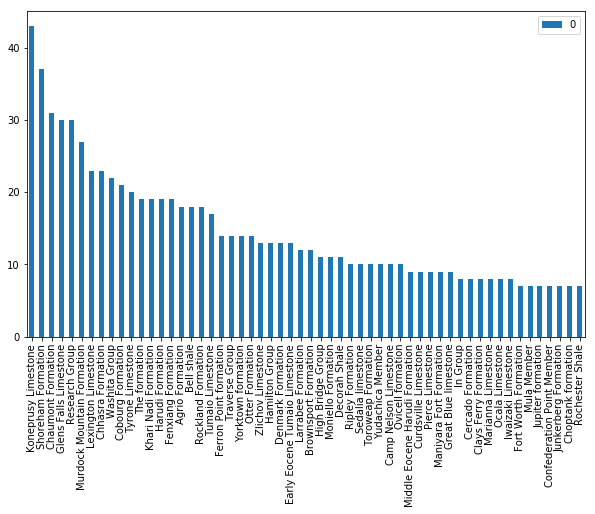

In [71]:
#width = 20
#height = 12
#plt.figure(figsize=(width, height))

counts = Counter([x for x in strat if x in common_strat])
df = pd.DataFrame.from_dict(counts, orient='index').sort_values(by = [0], ascending = False)
df.plot(kind='bar')

#%pylab inline
#pylab.rcParams['figure.figsize'] = (10, 6)

plt.show()

In [89]:
mc

[('Koneprusy Limestone', 43),
 ('Shoreham Formation', 37),
 ('Chaumont Formation', 31),
 ('Research Group', 30),
 ('Glens Falls Limestone', 30),
 ('Murdock Mountain Formation', 27),
 ('Chhasra Formation', 23),
 ('Lexington Limestone', 23),
 ('Washita Group', 22),
 ('Cobourg Formation', 21),
 ('Tyrone Limestone', 20),
 ('Fenxiang Formation', 19),
 ('The formation', 19),
 ('Khari Nadi Formation', 19),
 ('Harudi Formation', 19),
 ('Rockland Formation', 18),
 ('Agrio Formation', 18),
 ('Bell shale', 18),
 ('Tumaio Limestone', 17),
 ('Yorktown formation', 14),
 ('Ferron Point formation', 14),
 ('Traverse Group', 14),
 ('Otter Formation', 14),
 ('Hamilton Group', 13),
 ('Early Eocene Tumaio Limestone', 13),
 ('Denmark Formation', 13),
 ('Zlichov Limestone', 13),
 ('Brownsport Formation', 12),
 ('Larrabee Formation', 12),
 ('High Bridge Group', 11),
 ('Decorah Shale', 11),
 ('Moniello Formation', 11),
 ('Yudachica Member', 10),
 ('Ovicell formation', 10),
 ('Toroweap Formation', 10),
 ('Riple

In [77]:
' '.join(candidates[0]["sentence"])

"Herein designated from Munro 's syntype material is the lectotype : NHM BZ3529 ; small quarry east of Ravenstonedale , British National Grid Refer ence -LRB- BNGR -RRB- : NY 737 034 , Cumbria , England ; Semin ula -LRB- Composita -RRB- gregaria sub-zone , Ravenstonedale Limestone , Viséan -LRB- Chadian sub-stage -RRB- , Mississippian -LRB- Lower Carboniferous -RRB- ; M. Munro Collection ."

In [84]:
candidates[0]["TAXA"]["TAXA"][0][0].isupper()

False

In [85]:
c = [x for x in candidates if x["TAXA"]["TAXA"][0][0].isupper()]